In [ ]:
#how data are represented at each level (forward, backward, forward with padding on top) needs a little
    #experimentation to determine the best representation
    #also, is encoding at each layer really the best way? or just feeding the raw through?
    
#Outside web ips are going to be a problem/messy/noisy. Start by categorizing all outside ips by <OUTSIDE_IP>
    #instead of the ip address, or another 4 digit symbol to insert into the hex string.
    
#to help the models generalize more, for a given source ip address with probability p (say p = 0.1) 
    #use the token <OTHER_MACHINE>
    
#should we remove random parts of the header, i.e. checksum

#should I take out bias for RNNs?

#for the decoder,does the fork encoding need to happen ?
    #do we simply cat the hContext with the next words?
    
#Should the architecture just be encode, context and then prediction???

#Input data, should it have character and hex pair encoding as well?

In [1]:
#%matplotlib inline
import os
os.environ['THEANO_FLAGS'] = 'floatX=float32,device=gpu'

import sessionizer
import learningfunctions
import adversarialfunctions
import json
import subprocess
import cPickle
import sys
import binascii
import logging

import numpy as np
import random
from copy import copy

import blocks
from blocks.bricks import Linear, Softmax, Softplus, NDimensionalSoftmax, BatchNormalizedMLP, \
                                Rectifier, Logistic, Tanh, MLP
from blocks.bricks.recurrent import GatedRecurrent, Fork, LSTM
from blocks.initialization import Constant, IsotropicGaussian, Identity, Uniform
from blocks.bricks.cost import BinaryCrossEntropy, CategoricalCrossEntropy
from blocks.filter import VariableFilter
from blocks.roles import PARAMETER
from blocks.graph import ComputationGraph

import theano
from theano import tensor as T

sys.setrecursionlimit(100000)

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, CuDNN 4007)


In [34]:
maxPackets = 4
loadPrepedData = False  # load preprocessed data
dataPath = '/data/fs4/datasets/pcaps/smallFlows.pcap'  # path to data
#dataPath = '/data/fs4/home/bradh/bigFlows.pickle'  # path to data
savePath = '/data/fs4/home/bradh/outputs/'  # where to save outputs

packetTimeSteps = 40 # number of hex pairs (header chars / 2)
packetReverse = False # reverse the order of packets ala seq2seq
padOldTimeSteps = True # pad short sessions/packets at beginning(True) or end (False)
onlyEssentials = True  # extracts only length,protocol,frag,srcIP,dstIP,srcport,dstport from header
if onlyEssentials:  
    packetTimeSteps = 16

runname = 'unsup'#'attn8full4class'
rnnType = 'gru'  # gru or lstm
attentionEnc = False
vae = False

wtstd = 0.2  # standard dev for Isotropic weight initialization
dimIn = 257  # hex has 256 characters + the <EOP> character
dim = 100  # dimension reduction size
clippings = 1  # for gradient clipping
batch_size = 20  

epochs = 50 
lr = 0.0001
decay = 0.9
trainPercent = 0.9  # training testing split

module_logger = logging.getLogger(__name__)

# Data

In [3]:
#load and save files and models
def pickleFile(thing2save, file2save2 = None, filePath='/work/notebooks/drawModels/', fileName = 'myModels'):
    
    if file2save2 == None:
        f=file(filePath+fileName+'.pickle', 'wb')
    else:
        f=file(filePath+file2save2, 'wb')
        
    cPickle.dump(thing2save, f, protocol=cPickle.HIGHEST_PROTOCOL)

    f.close()
    
def loadFile(filePath):
    file2open = file(filePath, 'rb')
    loadedFile = cPickle.load(file2open)
    file2open.close()
    
    return loadedFile

In [4]:
#Making the hex dictionary
def hexTokenizer():
    hexstring = '0,	1,	2,	3,	4,	5,	6,	7,	8,	9,	A,	B,	C,	D,	E,	F,	10,	11,	12,	13,	14,	15,	16,	17,	18,	19\
    ,	1A,	1B,	1C,	1D,	1E,	1F,	20,	21,	22,	23,	24,	25,	26,	27,	28,	29,	2A,	2B,	2C,	2D,	2E,	2F,	30,	31,	32,	33,	34,	35\
    ,	36,	37,	38,	39,	3A,	3B,	3C,	3D,	3E,	3F,	40,	41,	42,	43,	44,	45,	46,	47,	48,	49,	4A,	4B,	4C,	4D,	4E,	4F,	50,	51\
    ,	52,	53,	54,	55,	56,	57,	58,	59,	5A,	5B,	5C,	5D,	5E,	5F,	60,	61,	62,	63,	64,	65,	66,	67,	68,	69,	6A,	6B,	6C,	6D\
    ,	6E,	6F,	70,	71,	72,	73,	74,	75,	76,	77,	78,	79,	7A,	7B,	7C,	7D,	7E,	7F,	80,	81,	82,	83,	84,	85,	86,	87,	88,	89\
    ,	8A,	8B,	8C,	8D,	8E,	8F,	90,	91,	92,	93,	94,	95,	96,	97,	98,	99,	9A,	9B,	9C,	9D,	9E,	9F,	A0,	A1,	A2,	A3,	A4,	A5\
    ,	A6,	A7,	A8,	A9,	AA,	AB,	AC,	AD,	AE,	AF,	B0,	B1,	B2,	B3,	B4,	B5,	B6,	B7,	B8,	B9,	BA,	BB,	BC,	BD,	BE,	BF,	C0,	C1\
    ,	C2,	C3,	C4,	C5,	C6,	C7,	C8,	C9,	CA,	CB,	CC,	CD,	CE,	CF,	D0,	D1,	D2,	D3,	D4,	D5,	D6,	D7,	D8,	D9,	DA,	DB,	DC,	DD\
    ,	DE,	DF,	E0,	E1,	E2,	E3,	E4,	E5,	E6,	E7,	E8,	E9,	EA,	EB,	EC,	ED,	EE,	EF,	F0,	F1,	F2,	F3,	F4,	F5,	F6,	F7,	F8,	F9\
    ,	FA,	FB,	FC,	FD,	FE,	FF'.replace('\t', '')

    hexList = [x.strip() for x in hexstring.lower().split(',')]
    hexList.append('<EOP>') #End Of Packet token
    #EOS token??????
    hexDict = {}

    for key, val in enumerate(hexList):
        if len(val) == 1:
            val = '0'+val
        hexDict[val] = key  #dictionary: k=hex, v=int  
    
    return hexDict

# Dictionary of IP communications

In [5]:
def srcIpDict(hexSessionDict):
    ''' 
    input: dictionary of key = sessions, value = list of HEX HEADERS of packets in session
    output: dictionary of key = source IP, value/subkey = dictionary of destination IPs, 
                                           subvalue = [[sport], [dport], [plen], [protocol]]
    
    '''
    
    srcIpDict = {}   
    uniqIPs = [] #some ips are dest only. this will collect all ips, not just srcIpDict.keys()
    
    for session in hexSessionDict.keys():
        
        for rawpacket in hexSessionDict[session][0]:
            packet = copy(rawpacket)
            
            dstIpSubDict = {}
            
            sourceMAC = packet[:12]
            destMAC = packet[12:24]
            srcip = packet[52:60]
            dstip = packet[60:68]
            sport = packet[68:72]
            dport = packet[72:76]
            plen = packet[32:36]
            protocol = packet[46:48]
            
            uniqIPs = list(set(uniqIPs) | set([dstip, srcip]))

            if srcip not in srcIpDict:
                dstIpSubDict[dstip] = [[sport], [dport], [plen], [protocol], [sourceMAC], [destMAC]]
                srcIpDict[srcip] = dstIpSubDict

            if dstip not in srcIpDict[srcip]:    
                srcIpDict[srcip][dstip] = [[sport], [dport], [plen], [protocol], [sourceMAC], [destMAC]]
            else:
                srcIpDict[srcip][dstip][0].append(sport)
                srcIpDict[srcip][dstip][1].append(dport)
                srcIpDict[srcip][dstip][2].append(plen)
                srcIpDict[srcip][dstip][3].append(protocol)
                srcIpDict[srcip][dstip][4].append(sourceMAC)
                srcIpDict[srcip][dstip][5].append(destMAC)
                
    return srcIpDict, uniqIPs

In [6]:
def dictUniquerizer(dictOdictsOlistOlists):
    '''
    input is the output of srcIpDict
    input: dictionary of dictionaries that have a list of lists 
           ex. srcIpDict[srcip][dstip] = [[sport], [dport], [plen], [protocol]]
    output: dictionary of dictionaries with list of lists with unique items in the final sublist
    
    WARNING: will overwrite your input dictionary. Make a copy if you want to preserve dictOdictsOlistOlists.
    '''
    #dictCopy
    for key in dictOdictsOlistOlists.keys():
        for subkey in dictOdictsOlistOlists[key].keys():
            for sublist in xrange(len(dictOdictsOlistOlists[key][subkey])):
                dictOdictsOlistOlists[key][subkey][sublist] = list(set(dictOdictsOlistOlists[key][subkey][sublist]))
    
    return dictOdictsOlistOlists

In [7]:
def oneHot(index, granular = 'hex'):
    if granular == 'hex':
        vecLen = 257
    else:
        vecLen = 17
    
    zeroVec = np.zeros(vecLen)
    zeroVec[index] = 1.0
    
    return zeroVec
 

In [9]:
#TODO: add character level encoding
def oneSessionEncoder(sessionPackets, hexDict, maxPackets = 2, packetTimeSteps = 100,
                      packetReverse = False, charLevel = False, padOldTimeSteps = True, 
                      onlyEssentials = False):    
            
    sessionCollect = []
    packetCollect = []
    
    if charLevel:
        vecLen = 17
    else:
        vecLen = 257
    
    if len(sessionPackets) > maxPackets: #crop the number of sessions to maxPackets
        sessionList = copy(sessionPackets[:maxPackets])
    else:
        sessionList = copy(sessionPackets)

    for rawpacket in sessionList:
        packet = copy(rawpacket)
        
        if onlyEssentials: #cat of length,protocol,frag,srcIP,dstIP,srcport,dstport
            packet = packet[32:36]+packet[44:46]+packet[46:48]+packet[52:60]+packet[60:68]+\
                     packet[68:72]+packet[72:76]
        
        packet = [hexDict[packet[i:i+2]] for i in xrange(0,len(packet)-2+1,2)] #get hex pairs
            
        if len(packet) >= packetTimeSteps - 1: #crop packet to length packetTimeSteps rel to hex pairs
            packet = packet[:packetTimeSteps - 1]
        
        packet = packet+[256] #add <EOP> end of packet token. now have packetTimeSteps
        
        packetCollect.append(packet)
        
        pacMat = np.array([oneHot(x) for x in packet]) #one hot encoding of packet into a matrix
        pacMatLen = len(pacMat)
        
        #padding packet
        if packetReverse:
            pacMat = pacMat[::-1]

        if pacMatLen < packetTimeSteps:
            #pad by stacking zeros on top of data so that earlier timesteps do not have information
            #padding the packet such that zeros are after the actual info for better translation
            if padOldTimeSteps:
                pacMat = np.vstack( ( np.zeros((packetTimeSteps-pacMatLen,vecLen)), pacMat) ) 
            else:
                pacMat = np.vstack( (pacMat, np.zeros((packetTimeSteps-pacMatLen,vecLen))) ) 

        sessionCollect.append(pacMat)

    #padding session
    sessionCollect = np.asarray(sessionCollect, dtype=theano.config.floatX)
    numPacketsInSession = sessionCollect.shape[0]
    
    if numPacketsInSession < maxPackets:
        #pad sessions to fit the 
        sessionCollect = np.vstack( (sessionCollect,np.zeros((maxPackets-numPacketsInSession, 
                                                             packetTimeSteps, vecLen))) )
    
    return sessionCollect, packetCollect

# Unsupervised feature extractor

### Initialization for both the unsupervised net and the classifier

In [ ]:
def clip_norm(g, c, n): 
    '''n is the norm, c is the threashold, and g is the gradient'''
    
    if c > 0: 
        g = T.switch(T.ge(n, c), g*c/n, g) 
    return g

def clip_norms(gs, c):
    norm = T.sqrt(sum([T.sum(g**2) for g in gs]))
    return [clip_norm(g, c, norm) for g in gs]

#def training(runname, rnnType, attentionEnc, vae, onlyEssentials, maxPackets, packetTimeSteps, 
#             packetReverse, padOldTimeSteps, wtstd, lr, decay, clippings, dimIn, dim, 
#             batch_size, epochs, trainPercent, dataPath, savePath, loadPrepedData = False):
#    print locals()
#    print

X = T.tensor4('inputs')
Y = T.matrix('targets')
linewt_init = IsotropicGaussian(wtstd)
line_bias = Constant(1.0)
rnnwt_init = IsotropicGaussian(wtstd)
rnnbias_init = Constant(0.0)
classifierWts = IsotropicGaussian(wtstd)
attnWts = IsotropicGaussian(wtstd)

learning_rate = theano.shared(np.array(lr, dtype=theano.config.floatX))
learning_decay = np.array(decay, dtype=theano.config.floatX)

###DATA PREP
print 'loading data'
if loadPrepedData:
    hexSessions = loadFile(dataPath)
else:
    sessioner = sessionizer.HexSessionizer(dataPath)
    hexSessions = sessioner.read_pcap()

hexSessions = sessionizer.removeBadSessionizer(hexSessions)
hexSessionsKeys = sessionizer.order_keys(hexSessions)
hexDict = hexTokenizer()

print 'initializing network graph'
###ENCODER RNN
if rnnType == 'gru':
    rnn = GatedRecurrent(dim=dim, weights_init = rnnwt_init, biases_init = rnnbias_init, name = 'gru')
    dimMultiplier = 2
else:
    rnn = LSTM(dim=dim, weights_init = rnnwt_init, biases_init = rnnbias_init, name = 'lstm')
    dimMultiplier = 4

fork = Fork(output_names=['linear', 'gates'],
            name='fork', input_dim=dimIn, output_dims=[dim, dim * dimMultiplier], 
            weights_init = linewt_init, biases_init = line_bias)

###CONTEXT RNN
if rnnType == 'gru':
    rnnContext = GatedRecurrent(dim=dim, weights_init = rnnwt_init, 
                                biases_init = rnnbias_init, name = 'gruContext')
else:
    rnnContext = LSTM(dim=dim, weights_init = rnnwt_init, biases_init = rnnbias_init, 
                      name = 'lstmContext')

forkContext = Fork(output_names=['linearContext', 'gatesContext'],
            name='forkContext', input_dim=dim, output_dims=[dim, dim * dimMultiplier], 
            weights_init = linewt_init, biases_init = line_bias)

###DECODER
if rnnType == 'gru':
    rnnDec = GatedRecurrent(dim=dimIn, weights_init = rnnwt_init, 
                            biases_init = rnnbias_init, name = 'gruDecoder')
else:
    rnnDec = LSTM(dim=dimIn, weights_init = rnnwt_init, biases_init = rnnbias_init, name = 'lstmDecoder')


forkDec = Fork(output_names=['declinear', 'decgates'],
            name='forkDec', input_dim=dim, output_dims=[dim, dimIn*dimMultiplier], 
            weights_init = linewt_init, biases_init = line_bias)

forkFinal = Fork(output_names=['finallinear', 'finalgates'],
            name='forkFinal', input_dim=dim, output_dims=[dimIn, dimIn*dimMultiplier], 
            weights_init = linewt_init, biases_init = line_bias)

#initialize the weights in all the functions
fork.initialize()
rnn.initialize()

forkContext.initialize()
rnnContext.initialize()
forkDec.initialize()

forkFinal.initialize()
rnnDec.initialize()

def onestepEnc(X):
        data1, data2 = fork.apply(X) 

        if rnnType == 'gru':
            hEnc = rnn.apply(data1, data2) 
        else:
            hEnc, _ = rnn.apply(data2)

        return hEnc, data1

[hEnc, data1], _ = theano.scan(onestepEnc, X) #(mini*numPackets, packetLen, 1, hexdictLen)

if attentionEnc:
    attentionmlpEnc = MLP(activations=[Tanh()], dims = [dim, 1], weights_init=classifierWts,
           biases_init=Constant(1.0))
    attentionmlpEnc.initialize()

    hEncAttn = T.reshape(hEnc, (-1, packetTimeSteps, dim))
    def onestepEncAttn(hEncAttn):

        preEncattn = attentionmlpEnc.apply(hEncAttn)
        attEncsoft = Softmax()
        attEncpyx = attEncsoft.apply(preEncattn.flatten())
        attEncpred = attEncpyx.flatten()
        attenc = T.mul(hEncAttn.dimshuffle(1,0), attEncpred).dimshuffle(1,0)

        return attEncpyx, attEncpred, attenc

    [attEncpyx, attEncpred, attenc], _ = theano.scan(onestepEncAttn, hEncAttn)

    hEncReshape = T.reshape(T.sum(attenc, axis = 1), (-1, maxPackets, 1, dim))

else:
    hEncReshape = T.reshape(hEnc[:,-1], (-1, maxPackets, 1, dim)) #[:,-1] takes the last rep for each packet
                                                             #(mini, numPackets, 1, dimReduced)                                                                      

def onestepContext(hEncReshape):

    data3, data4 = forkContext.apply(hEncReshape)

    if rnnType == 'gru':
        hContext = rnnContext.apply(data3, data4)
    else:
        hContext, _ = rnnContext.apply(data4)
    
    return hContext

hContext, _ = theano.scan(onestepContext, hEncReshape)

if vae:    
    zdata5, _ = forkDec.apply(hContext)

    def floatX(X):
        return np.asarray(X, dtype=theano.config.floatX)

    e = T.matrix()
    zdim = 100

    zfork = Fork(output_names=['mu', 'sigma'],
                name='vae', input_dim=dim, output_dims=[zdim, zdim], 
                weights_init = linewt_init, biases_init = line_bias)
    zfork.initialize()


    mu, sigma = zfork.apply(T.reshape(zdata5[:,1:], (-1, 100)))
    log_sigma = 0.5 * sigma # ? on the 0.5
    z = mu + T.exp(log_sigma) * e # e is a vector of random numbers (noise)

    data5 = T.reshape(z, (-1, maxPackets-1, 1, dim))
else:
    data5, _ = forkDec.apply(hContext)
    data5 = data5[:,1:]
    
data5 =  T.addbroadcast(data5, 2) 
data7 = T.concatenate((data5, T.reshape(data1, (-1, maxPackets, packetTimeSteps, dim))[:,1:,:-1]),
                       axis = 2) + data5

def onestepDec(data7):
    data8, data9 = forkFinal.apply(data7) #forkFinal transforms back to original dimIn
    
    if rnnType == 'gru':
        hDec = rnnDec.apply(data8, data9) 
    else:
        hDec, _ = rnnDec.apply(data9)
        #hDec = hinit #hDec shape = (batch_size*(maxPackets-1), packetTimeSteps, 257)
    
    return hDec


hDec, _ = theano.scan(onestepDec, data7)
hDecReshape = T.reshape(hDec, (-1, packetTimeSteps, dimIn))

softmax = NDimensionalSoftmax()
softout = softmax.apply(hDecReshape, extra_ndim = 1)
predX = T.reshape(T.reshape(X,(-1, maxPackets, packetTimeSteps, dimIn))[:,1:,:,:], 
                  (-1, packetTimeSteps, dimIn))

precost = predX*T.log(softout) + (1-predX)*T.log(1-softout)
precost2 = T.mean(-T.sum(T.sum(precost, axis = 2), axis = 1))

if vae:
    #recon_cost = T.mean(CategoricalCrossEntropy().apply(predX, softout))
    recon_cost = precost2
    kl_cost = 0.5 * T.sum(1 + 2 * log_sigma - mu ** 2 - T.exp(2 * log_sigma))
    cost = recon_cost - kl_cost

else:
    #cost = T.mean(precost2)
    cost = T.mean(CategoricalCrossEntropy().apply(predX, softout))

cg = ComputationGraph([cost])

learning_rate = theano.shared(np.array(0.0001, dtype=theano.config.floatX))
learning_decay = np.array(0.9, dtype=theano.config.floatX)

params = VariableFilter(roles = [PARAMETER])(cg.variables)
learning = learningfunctions.Learning(cost,params,learning_rate,l1=0.,l2=0.,maxnorm=0.,c=clippings)
updates = learning.Adam() 

###To check gradients for explosion/shrinkage
gradients = T.grad(cost, params)
gradients = clip_norms(gradients, clippings)
gradientFun = theano.function([X], gradients, allow_input_downcast=True)

print "compiling you beautiful person"

if vae:
    inputs = [X,e]
    predictvae = theano.function(inputs, [softout, hContext, data5, attEncpred], allow_input_downcast=True)
else:
    inputs = [X]
    predict = theano.function(inputs, [softout, hContext], allow_input_downcast=True)

train = theano.function(inputs, [cost, hContext], updates = updates, allow_input_downcast=True)
print "finished compiling"

loading data
starting reading pcap file
finished reading pcap file
initializing network graph


In [ ]:
epochCost = []
gradNorms = []
contextCollect = []

epochs = 80
iteration = 0
trainIndex = int(len(hexSessionsKeys)*trainPercent)

for epoch in xrange(epochs):
    costCollect = []
    
    for start, end in zip(range(0, trainIndex,batch_size), range(batch_size, trainIndex, batch_size)):
        trainingSessions = []
        
        for trainKey in range(start, end):
            sessionForEncoding = list(hexSessions[hexSessions.keys()[trainKey]][0])
            
            #encode a normal session
            #oneHotSes = oneSessionEncoder(sessionForEncoding,hexDict = hexDict, packetReverse=packetReverse, 
            #                              padOldTimeSteps = padOldTimeSteps, maxPackets = maxPackets,
            #                              packetTimeSteps = packetTimeSteps)
            #trainingSessions.append(oneHotSes[0])
            #trainingTargets.append(normalTarget)
            
            #encode an abby normal session
            
            oneHotSes = oneSessionEncoder(sessionForEncoding,
                                              hexDict = hexDict,
                                              packetReverse=packetReverse, 
                                              padOldTimeSteps = padOldTimeSteps, 
                                              maxPackets = maxPackets, 
                                              packetTimeSteps = packetTimeSteps)
            
            trainingSessions.append(oneHotSes[0])
            
        sessionsMinibatch = np.asarray(trainingSessions).reshape((-1, packetTimeSteps, 1, dimIn))        
    
        
        if vae:
            costfun = train(sessionsMinibatch, np.random.randn(batch_size, zdim))
        else:
            costfun = train(sessionsMinibatch)
        costCollect.append(costfun[0])
        
        if iteration == 0:
            print 'you are amazing'
            
        iteration+=1
        
        #if iteration%80 == 0:
        #    learning_rate.set_value(learning_rate.get_value() * learning_decay)
        #    print '   learning rate: ', learning_rate.get_value()
        
        if iteration%1500 == 0:
            pickleFile(train, filePath=savePath,
                        fileName=runname+'TRAINunsup'+str(iteration))
            pickleFile(predict, filePath=savePath,
                        fileName=runname+'PREDICTunsup'+str(iteration))
        
    ####SAVE COST TO FILE 
    if epoch%2 == 0:     
        print 
        print 'Epoch: ', epoch
        
        epochCost.append(np.mean(costCollect))
        contextCollect.append(costfun[-1][:4])
        
        print 'Epoch cost average: ', epochCost[-1]
        grads = gradientFun(sessionsMinibatch)
        for gra in range(len(grads)):
            print '  gradient norms: ', params[gra], ' ', np.linalg.norm(grads[gra])
        
    #np.savetxt(runname+"_COST.csv", epochCost, delimiter=",")
#return predict

In [27]:
#with attention ... it sucks

you are amazing

Epoch:  0
Epoch cost average:  4.32822
  gradient norms:  state_to_state   0.0331076
  gradient norms:  state_to_gates   0.0177075
  gradient norms:  initial_state   0.0628772
  gradient norms:  b   0.00402229
  gradient norms:  W   0.102381
  gradient norms:  b   0.00623695
  gradient norms:  W   0.161302
  gradient norms:  b   0.0143431
  gradient norms:  W   0.108183
  gradient norms:  state_to_state   0.0420491
  gradient norms:  state_to_gates   0.0213818
  gradient norms:  initial_state   0.0101964
  gradient norms:  b   0.00436129
  gradient norms:  W   0.0288752
  gradient norms:  b   0.0103315
  gradient norms:  W   0.0683561
  gradient norms:  b   0.000149985
  gradient norms:  W   0.00189305
  gradient norms:  state_to_state   0.0583042
  gradient norms:  state_to_gates   0.0206557
  gradient norms:  initial_state   0.00408746
  gradient norms:  b   0.00316522
  gradient norms:  W   0.00138826
  gradient norms:  b   0.0204615
  gradient norms:  W   0.0135455

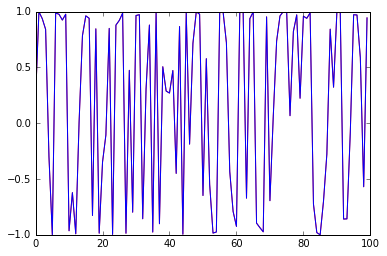

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
tester = predict(sessionsMinibatch)[1][:,-1] #new
t = range(len(tester[0].flatten()))
plt.plot(t, tester[0].flatten(), 'r', t, tester[1].flatten(), 'b')
plt.show()

In [33]:
predict(sessionsMinibatch)[1][:,-1]

array([[[ 0.22095898,  0.99890143,  0.9367426 , ...,  0.58765399,
         -0.5694108 ,  0.94362152]],

       [[ 0.22095898,  0.99890143,  0.9367426 , ...,  0.58765399,
         -0.5694108 ,  0.94362152]],

       [[ 0.22095898,  0.99890143,  0.9367426 , ...,  0.58765399,
         -0.5694108 ,  0.94362152]],

       ..., 
       [[ 0.91613644,  0.98158693,  0.42870322, ...,  0.99050605,
         -0.51942557,  0.95266026]],

       [[ 0.22095898,  0.99890143,  0.9367426 , ...,  0.58765399,
         -0.5694108 ,  0.94362152]],

       [[ 0.22095898,  0.99890143,  0.9367426 , ...,  0.58765399,
         -0.5694108 ,  0.94362152]]], dtype=float32)

In [ ]:
trainIndex = int(len(hexSessionsKeys)*trainPercent)

epochCost = []
gradNorms = []
trainAcc = []
testAcc = []

costCollect = []
trainCollect = []

print 'training begins'
iteration = 0
for epoch in xrange(epochs):

    #iteration/minibatch
    for start, end in zip(range(0, trainIndex, batch_size),
                          range(batch_size, trainIndex, batch_size)):

        trainingTargets = []
        trainingSessions = []
        for trainKey in range(start, end):
            sessionForEncoding = hexSessions[hexSessions.keys()[trainKey]][0]

            adfun = adversarialfunctions.Adversary(sessionForEncoding)
            adversaryList = [sessionForEncoding, 
                             adfun.dstIpSwapOut(comsDict, uniqIPs),
                             adfun.portDirSwitcher(),
                             adfun.ipDirSwitcher()
                             #adfun.noisyPacketMaker(maxPackets, packetTimeSteps, percentNoisy = 0.2)
                             ]
            if binaryTarget:
                # choose normal and one of the abnormal types
                abbyIndex = random.sample([0, random.sample(xrange(1,len(adversaryList)), 1)[0]], 1)[0]
                if abbyIndex == 0:
                    targetClasses = [0,1]
                else:
                    targetClasses = [1,0]
            else:
                assert len(adversaryList)==numClasses
                abbyIndex = random.sample(range(len(adversaryList)), 1)[0]
                targetClasses = [0]*numClasses
                targetClasses[abbyIndex] = 1

            abbyOneHotSes = oneSessionEncoder(adversaryList[abbyIndex],
                                              hexDict = hexDict,
                                              packetReverse=packetReverse, 
                                              padOldTimeSteps = padOldTimeSteps, 
                                              maxPackets = maxPackets, 
                                              packetTimeSteps = packetTimeSteps,
                                              onlyEssentials = onlyEssentials)

            trainingSessions.append(abbyOneHotSes[0])
            trainingTargets.append(np.array(targetClasses, dtype=theano.config.floatX))

        sessionsMinibatch = np.asarray(trainingSessions).reshape((-1, packetTimeSteps, 1, dimIn))
        targetsMinibatch = np.asarray(trainingTargets)

        costfun = classifierTrain(sessionsMinibatch, targetsMinibatch)

        costCollect.append(costfun[0])
        trainCollect.append(np.mean(np.argmax(costfun[-1],axis=1) == np.argmax(targetsMinibatch, axis=1)))

        iteration+=1

        if iteration == 1:
            print 'you are amazing'

        # decay learning rate
        #if iteration%500 == 0:
        #    learning_rate.set_value(learning_rate.get_value() * learning_decay)

        # collect training stats
        if iteration%200 == 0:
            print '   Iteration: ', iteration
            print '   Cost: ', np.mean(costCollect[-20:])
            print '   TRAIN accuracy: ', np.mean(trainCollect[-20:])
            print

            ###To check gradients for explosion/shrinkage
            #grads = gradientFun(sessionsMinibatch, targetsMinibatch)
            #for gra in grads:
            #    print '  gradient norms: ', np.linalg.norm(gra)

            np.savetxt(savePath+runname+"_TRAIN.csv", trainCollect[::50], delimiter=",")
            np.savetxt(savePath+runname+"_COST.csv", costCollect[::50], delimiter=",")

        #testing accuracy
        if iteration%500 == 0:
            predtar, acttar, testCollect = predictClass(classifierPredict, hexSessions, comsDict, 
                                                        uniqIPs, hexDict,
                                                        hexSessionsKeys, binaryTarget, 
                                                        numClasses, onlyEssentials, 
                                                        trainPercent, dimIn,
                                                        maxPackets, packetTimeSteps, 
                                                        padOldTimeSteps)

            binaryPrecisionRecall(predtar, acttar, numClasses)
            testAcc.append(testCollect)
            np.savetxt(savePath+runname+"_TEST.csv", testAcc, delimiter=",")

        #save the models
        #if iteration%1500 == 0:
        #    pickleFile(classifierTrain, filePath=savePath,
        #                fileName=runname+'TRAIN'+str(iteration))
        #    pickleFile(classifierPredict, filePath=savePath,
        #                fileName=runname+'PREDICT'+str(iteration))

    epochCost.append(np.mean(costCollect[-50:]))
    trainAcc.append(np.mean(trainCollect[-50:]))

    print 'Epoch: ', epoch
    #module_logger.debug('Epoch:%r',epoch)
    print 'Epoch cost average: ', epochCost[-1]
    print 'Epoch TRAIN accuracy: ', trainAcc[-1]

#return classifierTrain, classifierPredict

In [ ]:
#TODO: expose classifier dim
train, predict = training(runname, rnnType, attentionEnc, attentionContext, onlyEssentials, maxPackets, packetTimeSteps, 
             packetReverse, padOldTimeSteps, wtstd, lr, decay, clippings, dimIn, dim, binaryTarget, numClasses, 
             batch_size, epochs, trainPercent, dataPath, savePath, loadPrepedData)

In [ ]:
#with context attn

In [ ]:
#no attention